In [78]:
# To use louvain algorithm
!pip3 install python-louvain
# To use progressbar
!pip3 install progressbar2

In [79]:
import pandas as pd
import numpy as np
import math as m
import time 
from pycowview.data import csv_read_FA
from pycowview.manipulate import unique_cows
from pycowview.metrics import interaction_time
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
import os
import community
from collections import defaultdict,Counter
import progressbar
import random
import itertools 
from sklearn.metrics.cluster import normalized_mutual_info_score

In [80]:
# Weighted version!
# This function will get the path of each csv file
def findAllFile(base):
    for root, ds, fs in os.walk(base):
        for f in fs:
            if f.endswith('.csv'):
                fullname = os.path.join(root, f)
                yield fullname

# Input is the folders where the time matrix and cowlist are saved
# Output is a list which consists of 14 dictionaries
# The structure of dictionary:Cowlist,TimeMatrix,AajacencyMatrix_binary,Unweighted_Graph
def time_matrix_to_graph(tm_folder,cl_folder):
    dict_list = []
    i = 0
    tmlist = list(findAllFile(tm_folder))
    tmlist.sort()
    cllist = list(findAllFile(cl_folder))
    cllist.sort()
    for tm,cl in zip(tmlist,cllist):
        # print(tm,cl)
        # Get the path of csv
        # get cowlist
        cowlist = np.loadtxt(cl,delimiter=",").astype(int)
        # load original time matrix from csv and process it to be an adjacency Matrix
        OM = np.asmatrix(np.loadtxt(tm,delimiter=","))
        
        # Get unweighted adjacency matrix(binary)
        # init adjacency matrix
        #AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        #epsilon = 1800
        # just consider if there is an edge between two cows, the edge is unweighted
        #AM[OM >= epsilon] = 1
        #AM[OM < epsilon] = 0 
        #np.fill_diagonal(AM,0)
        # Get graph from AM, no-direct and no-weight graph
        #G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        
        # Get weighted adjacency matrix
        # load original matrix from csv and process it to be an adjacency Matrix
        AM = np.zeros((OM.shape))
        # set the threshold to be 30 minutes(1800 seconds)
        epsilon = 1800
        # consider if there is an edge between two cows, the edge is weighted
        maxnr=np.amax(OM)
        AM=np.where(OM<=epsilon,0,(OM-epsilon)/(maxnr-epsilon))
        np.fill_diagonal(AM,0)
        # Get graph from AM, no-direct and weighted graph
        G_AM_temp = nx.from_numpy_matrix(AM,parallel_edges=False,create_using = nx.Graph())
        
        # Make sure the order of cowlist is the same as the row name!
        print('Shape of matrix:',AM.shape)
        print('number of nodes in graph',len(G_AM_temp),'length of cowlist',len(cowlist))
        mapping = dict(zip(G_AM_temp, cowlist))
        #print(mapping)
        # Rename the nodes
        G_AM = nx.relabel_nodes(G_AM_temp, mapping)
        
        # Get the dict of the collection(CL,TM,AM_weighted,Graph)
        data_dict = dict(CL=cowlist,TM=OM,AM_weighted=AM,Graph=G_AM)
        print('Document No.',i)
        print('TM path:',tm,'CL path:',cl)
        i = i + 1
        dict_list.append(data_dict)

    print('The length of the list: ',len(dict_list))
    return dict_list

In [81]:
def community_Louvain(i,G):
    print('This is the result of day %d'%(i+1))
    
    # Remove the nodes whose degree is zero
    nodes_removed = [node for node,degree in dict(G.degree()).items() if degree == 0]
    G.remove_nodes_from(nodes_removed)
    print(len(nodes_removed),'nodes whose degree is zero are removed')
    
    # Louvain algorithm
    partition = community.best_partition(G,weight = 'weight',randomize=False)
    num_communities = max(partition.values())
    
    # create a dict object:{community1:[nodelist],community2:[nodelist],......}
    # community1:[nodelist] is a tuple
    communities_Louvain = defaultdict(list) 
    for k, v in partition.items():
        communities_Louvain[v].append(k)    
    np.save('./community/Louvain_weighted/Day_%d_Louvain_weighted_communities.npy'%(i+1), communities_Louvain)
    
    #read the dict from file
    #communities_Louvain = np.load('./community/Louvain/Day_%d_Louvain_Unweighted_communities.npy', allow_pickle='TRUE')
    #print(communities_Louvain)

    num_communities = max(partition.values())
    len_Louvain = len(communities_Louvain)
    print('max No. of community:',num_communities)
    print('num of communities:',len_Louvain)

    # Colormap for plotting
    color_Louvain = 0
    random.seed(7)
    total_colors = list(mpl.colors.get_named_colors_mapping())
    total_colors.remove('black')
    color_map_Louvain = random.sample(total_colors,len_Louvain)

    # Plot the figure
    plt.figure(figsize=(15, 15))  # image size
    pos = nx.fruchterman_reingold_layout(G, scale = 1) # position of nodes
    degree_dict = dict(G.degree())
    nx.draw_networkx(G, pos, node_size=5,width=0.05, alpha=1, with_labels=False)
    for community_Louvain in communities_Louvain.items():
        
        node_list = community_Louvain[1]
        edge_list = list(itertools.chain.from_iterable([list(G.edges(node)) for node in node_list]))
        label_list = {}
        for node in node_list:
            #set the node name as the key and the label as its value 
            label_list[node] = node 
        community_degree_dict = {key: value for key, value in degree_dict.items() if key in node_list}
        node_size_list = [d*20 for d in community_degree_dict.values()]
        
        nx.draw_networkx_nodes(G, pos , nodelist = node_list, node_size = node_size_list, node_color = color_map_Louvain[color_Louvain],alpha = 0.7)
        nx.draw_networkx_edges(G, pos , edgelist = edge_list, edge_color = color_map_Louvain[color_Louvain],alpha = 0.2)
        nx.draw_networkx_labels(G, pos, label_list, font_size = 8, font_color = color_map_Louvain[color_Louvain],alpha = 0.7)
        color_Louvain += 1
    plt.savefig('./community/Louvain_weighted/Day%d_weighted_Community.png'%(i+1))
    plt.show()
    
    return nodes_removed, communities_Louvain, partition

In [82]:
def compute_NMI(day1,day2):
    list1 = []
    list2 = []
    key1set = set(sorted(partition_14days[day1-1]))
    key2set = set(sorted(partition_14days[day2-1]))
    keylist = list(key1set&key2set)
    keylist.sort()
    i = 0
    for key in keylist:
        list1.append(partition_14days[0].get(key,-1))
        list2.append(partition_14days[1].get(key,-1))
        #i = i+1
        #print(i,key)
    #print(list1)
    #print(list2)
    return normalized_mutual_info_score(list1,list2)

In [83]:
# This part is used to process the time matrices
tm_folder = './time_matrix'
cl_folder = './cow_list'
data_dict_list = time_matrix_to_graph(tm_folder,cl_folder)

Shape of matrix: (213, 213)
number of nodes in graph 213 length of cowlist 213
Document No. 0
TM path: ./time_matrix/Time_FA_20201016T000000UTC.csv CL path: ./cow_list/Cow_list_20201016T000000UTC.csv
Shape of matrix: (212, 212)
number of nodes in graph 212 length of cowlist 212
Document No. 1
TM path: ./time_matrix/Time_FA_20201017T000000UTC.csv CL path: ./cow_list/Cow_list_20201017T000000UTC.csv
Shape of matrix: (219, 219)
number of nodes in graph 219 length of cowlist 219
Document No. 2
TM path: ./time_matrix/Time_FA_20201018T000000UTC.csv CL path: ./cow_list/Cow_list_20201018T000000UTC.csv
Shape of matrix: (208, 208)
number of nodes in graph 208 length of cowlist 208
Document No. 3
TM path: ./time_matrix/Time_FA_20201019T000000UTC.csv CL path: ./cow_list/Cow_list_20201019T000000UTC.csv
Shape of matrix: (209, 209)
number of nodes in graph 209 length of cowlist 209
Document No. 4
TM path: ./time_matrix/Time_FA_20201020T000000UTC.csv CL path: ./cow_list/Cow_list_20201020T000000UTC.csv


  0% (0 of 14) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

This is the result of day 1
0 nodes whose degree is zero are removed
max No. of community: 10
num of communities: 11


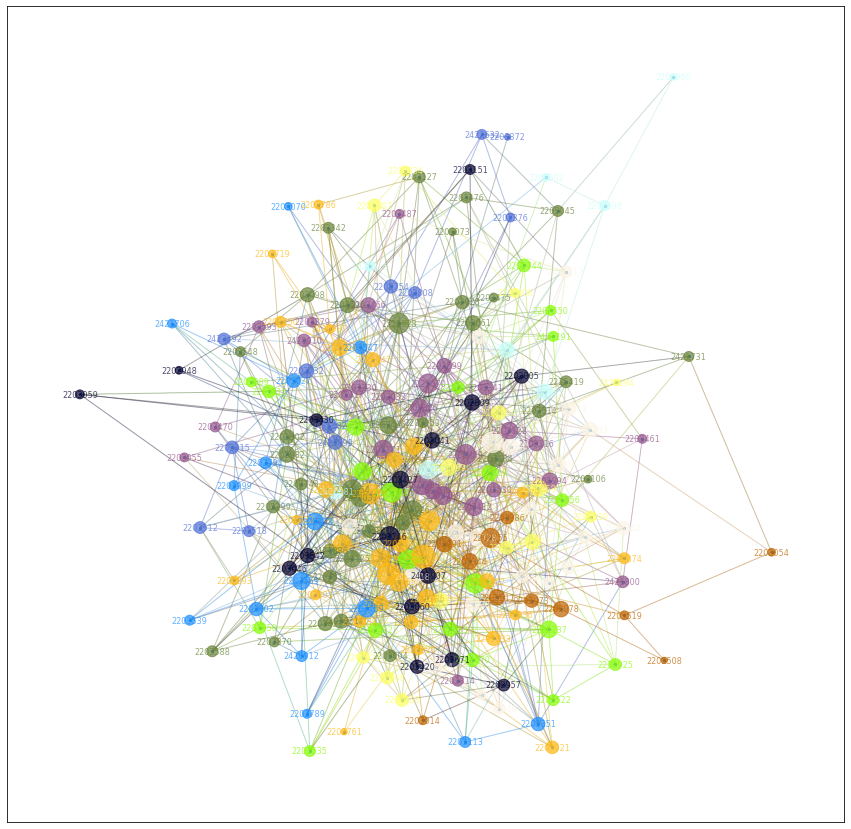

  7% (1 of 14) |#                        | Elapsed Time: 0:00:01 ETA:   0:00:15

This is the result of day 2
0 nodes whose degree is zero are removed
max No. of community: 11
num of communities: 12


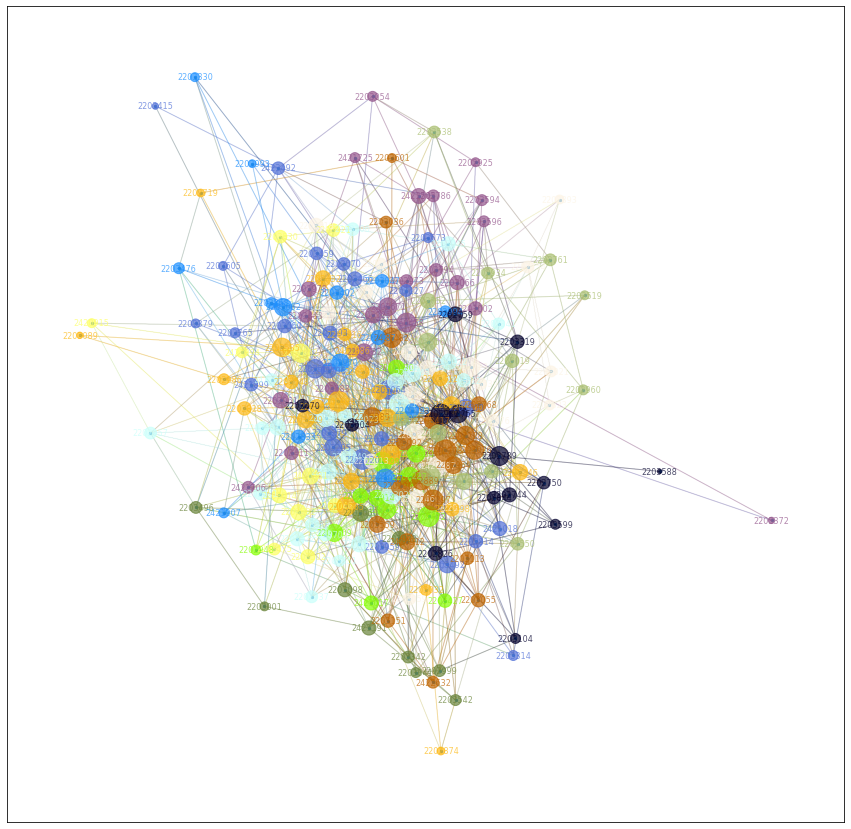

 14% (2 of 14) |###                      | Elapsed Time: 0:00:02 ETA:   0:00:13

This is the result of day 3
0 nodes whose degree is zero are removed
max No. of community: 9
num of communities: 10


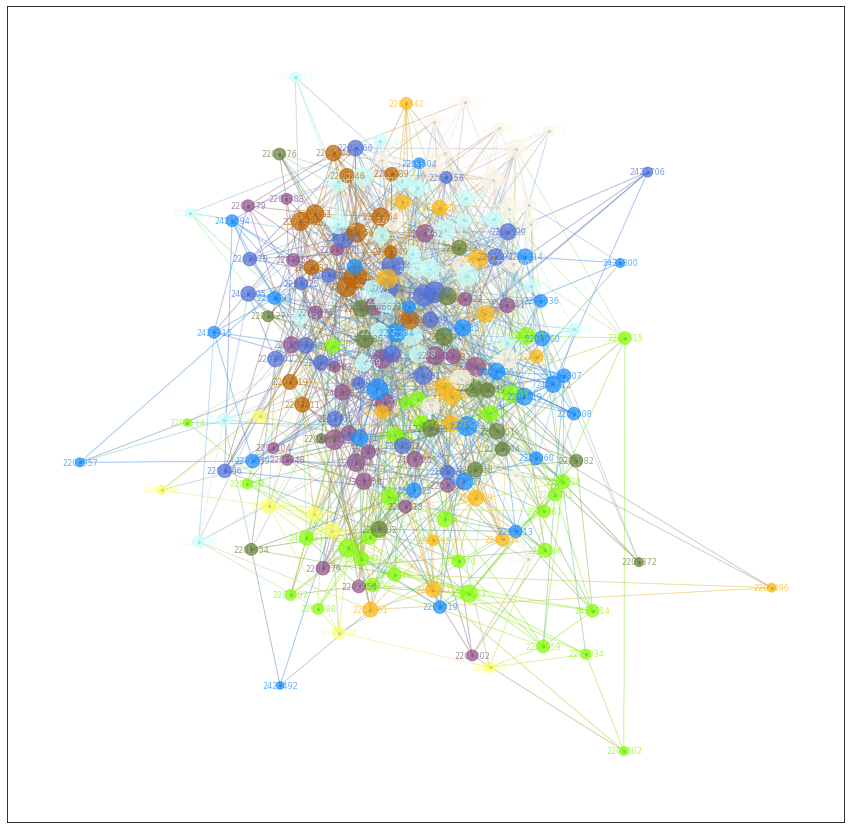

 21% (3 of 14) |#####                    | Elapsed Time: 0:00:03 ETA:   0:00:12

This is the result of day 4
1 nodes whose degree is zero are removed
max No. of community: 11
num of communities: 12


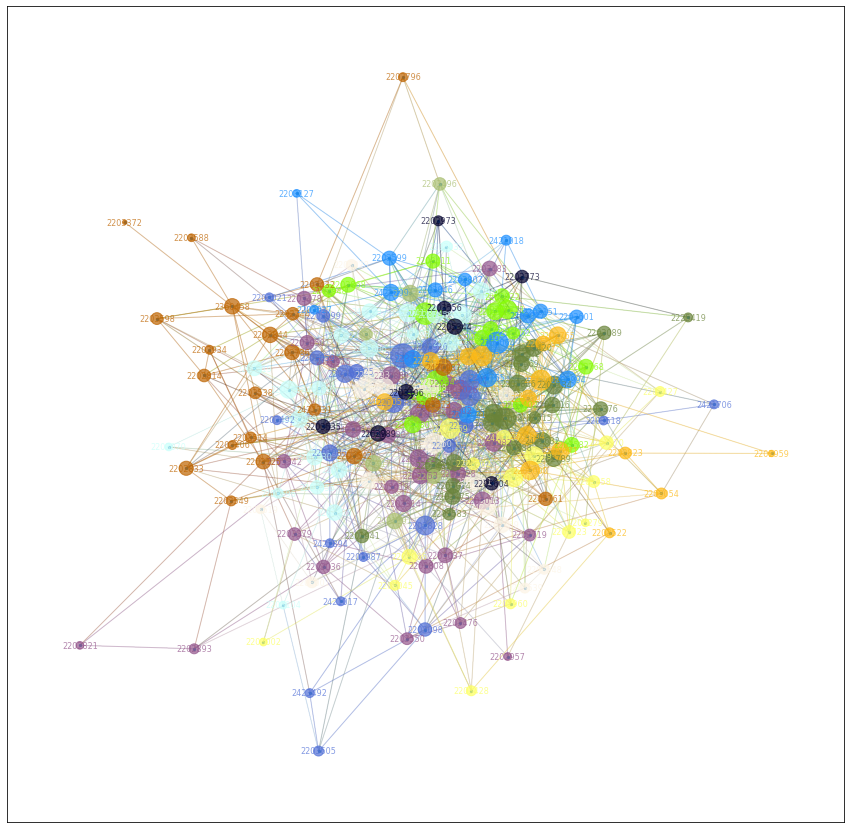

 28% (4 of 14) |#######                  | Elapsed Time: 0:00:04 ETA:   0:00:11

This is the result of day 5
0 nodes whose degree is zero are removed
max No. of community: 12
num of communities: 13


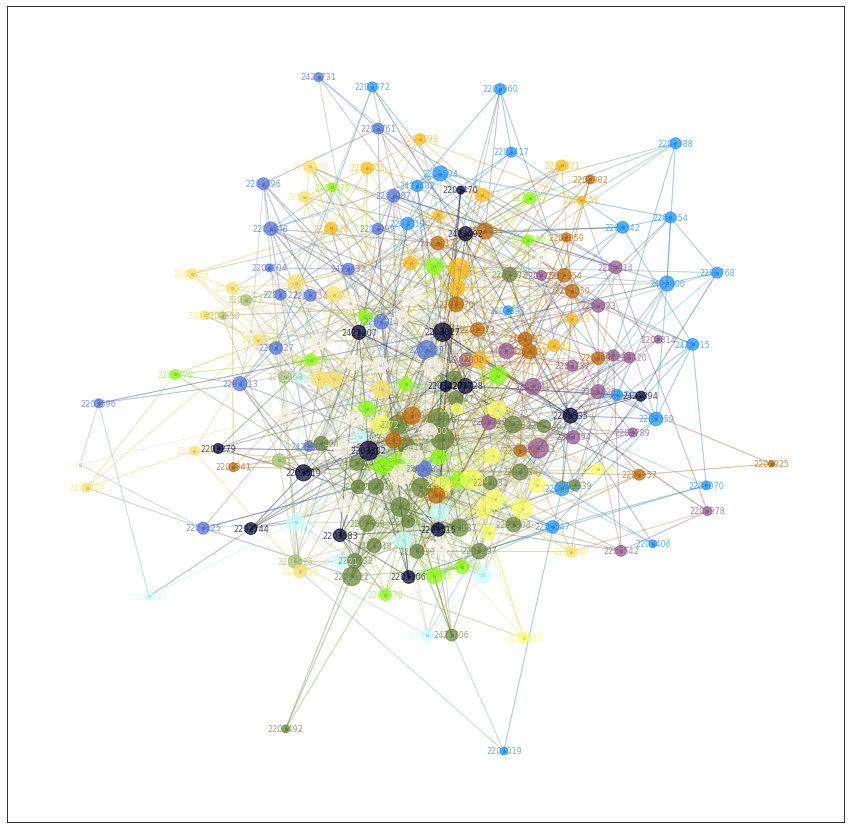

 35% (5 of 14) |########                 | Elapsed Time: 0:00:05 ETA:   0:00:11

This is the result of day 6
1 nodes whose degree is zero are removed
max No. of community: 11
num of communities: 12


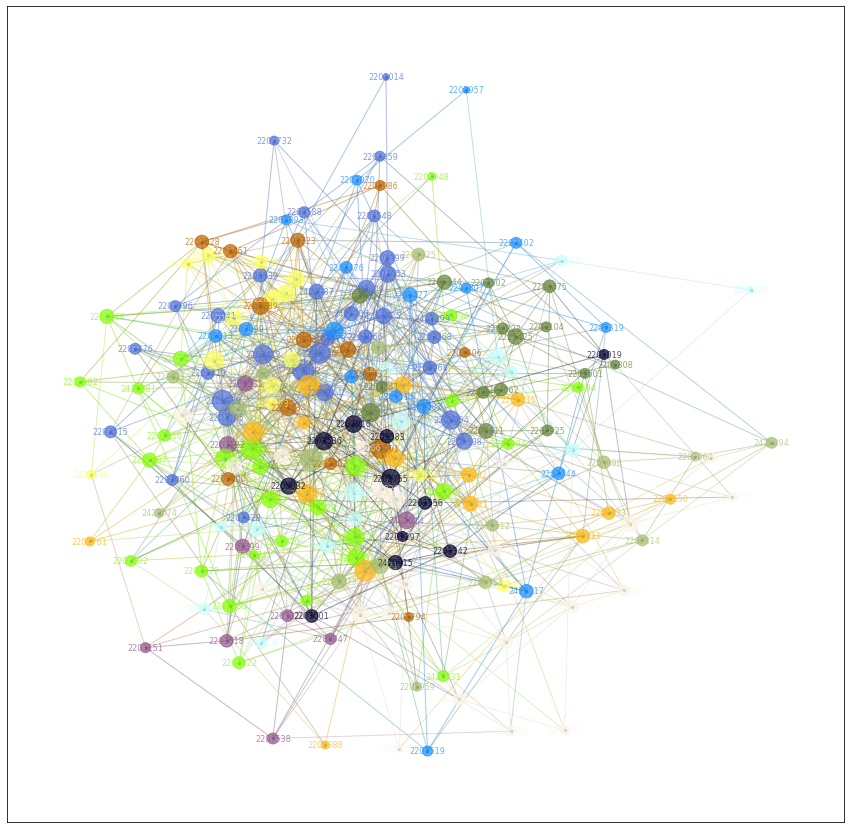

 42% (6 of 14) |##########               | Elapsed Time: 0:00:07 ETA:   0:00:12

This is the result of day 7
0 nodes whose degree is zero are removed
max No. of community: 12
num of communities: 13


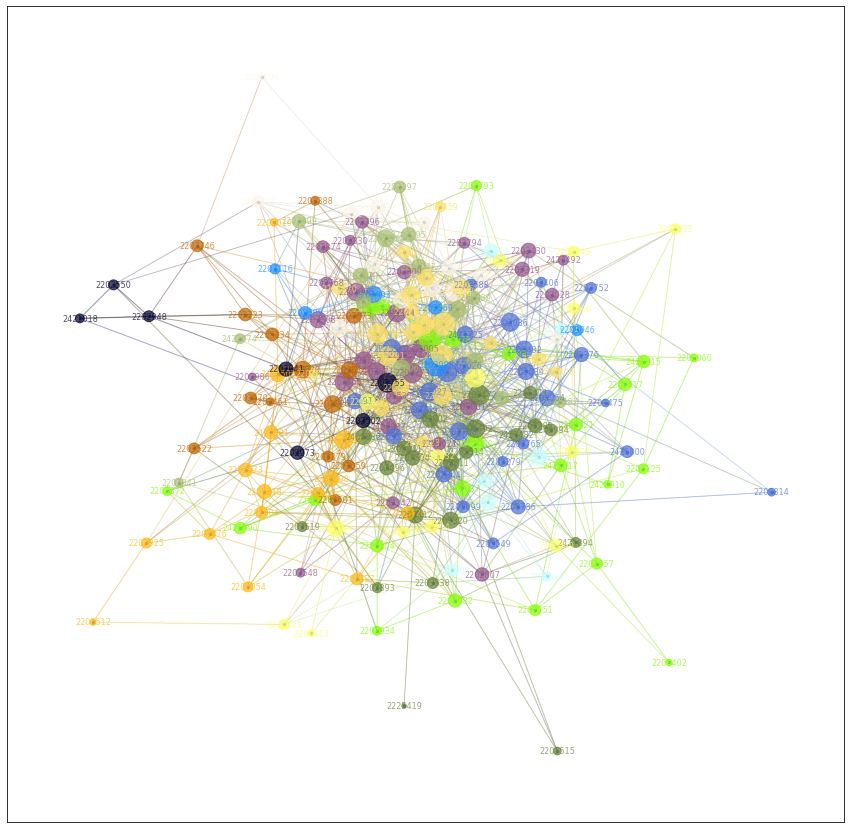

 50% (7 of 14) |############             | Elapsed Time: 0:00:08 ETA:   0:00:09

This is the result of day 8
2 nodes whose degree is zero are removed
max No. of community: 11
num of communities: 12


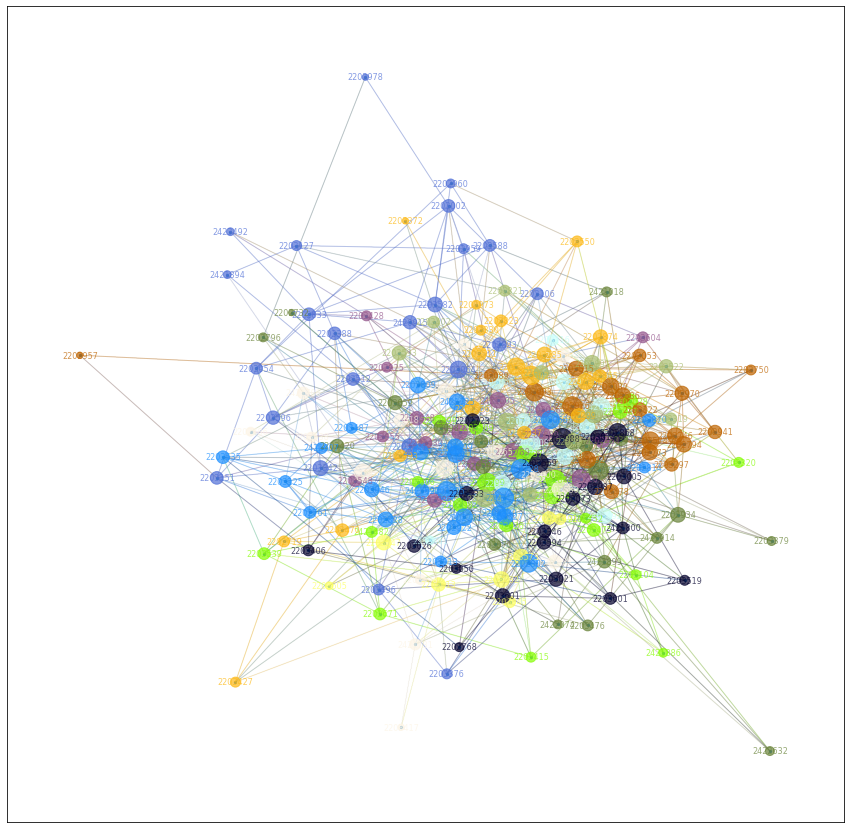

 57% (8 of 14) |##############           | Elapsed Time: 0:00:10 ETA:   0:00:07

This is the result of day 9
0 nodes whose degree is zero are removed
max No. of community: 10
num of communities: 11


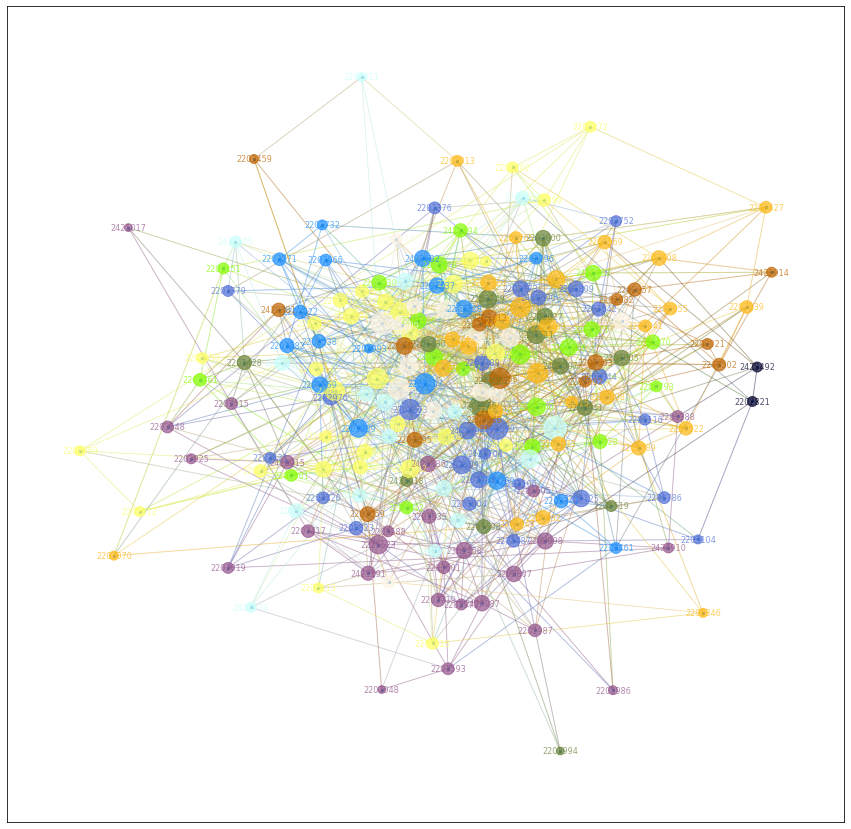

 64% (9 of 14) |################         | Elapsed Time: 0:00:11 ETA:   0:00:06

This is the result of day 10
0 nodes whose degree is zero are removed
max No. of community: 11
num of communities: 12


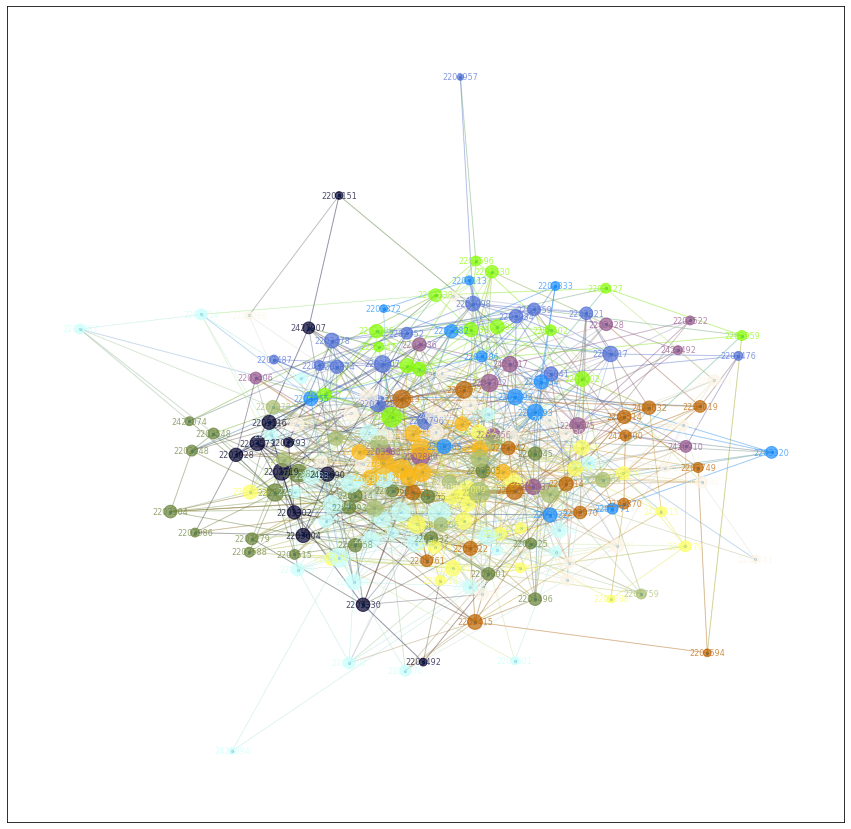

 71% (10 of 14) |#################       | Elapsed Time: 0:00:12 ETA:   0:00:04

This is the result of day 11
0 nodes whose degree is zero are removed
max No. of community: 10
num of communities: 11


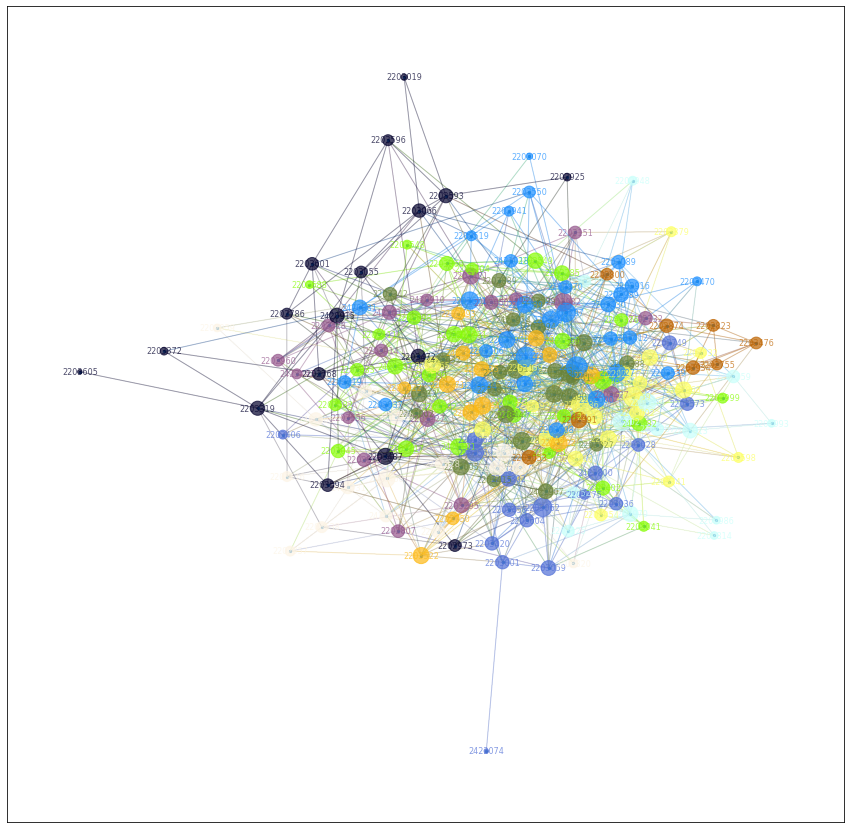

 78% (11 of 14) |##################      | Elapsed Time: 0:00:13 ETA:   0:00:03

This is the result of day 12
0 nodes whose degree is zero are removed
max No. of community: 12
num of communities: 13


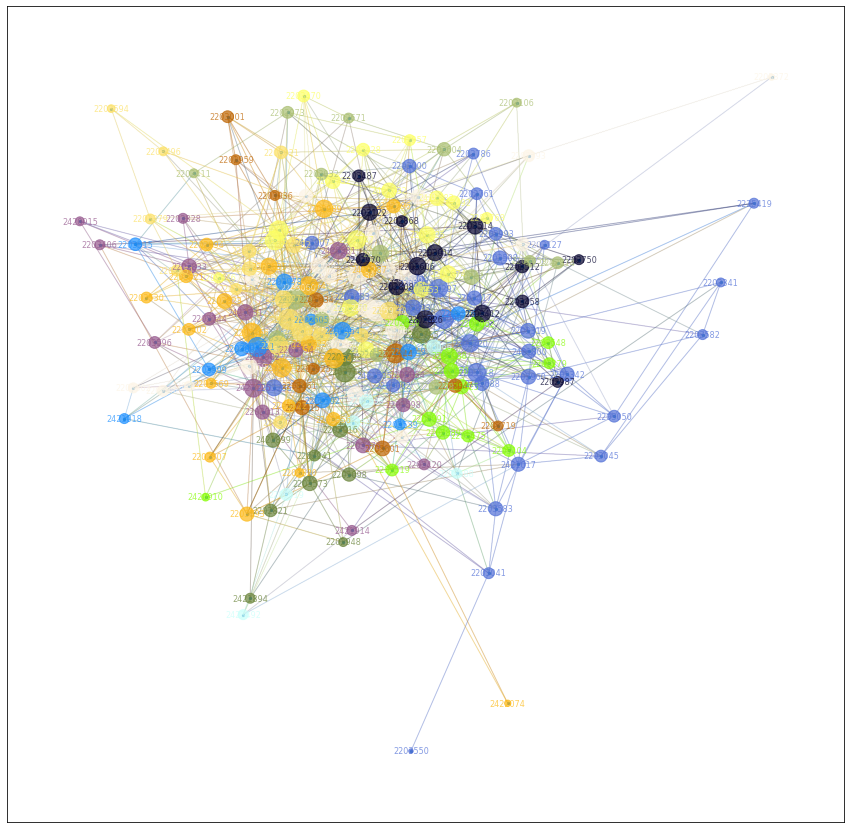

 85% (12 of 14) |####################    | Elapsed Time: 0:00:14 ETA:   0:00:02

This is the result of day 13
0 nodes whose degree is zero are removed
max No. of community: 11
num of communities: 12


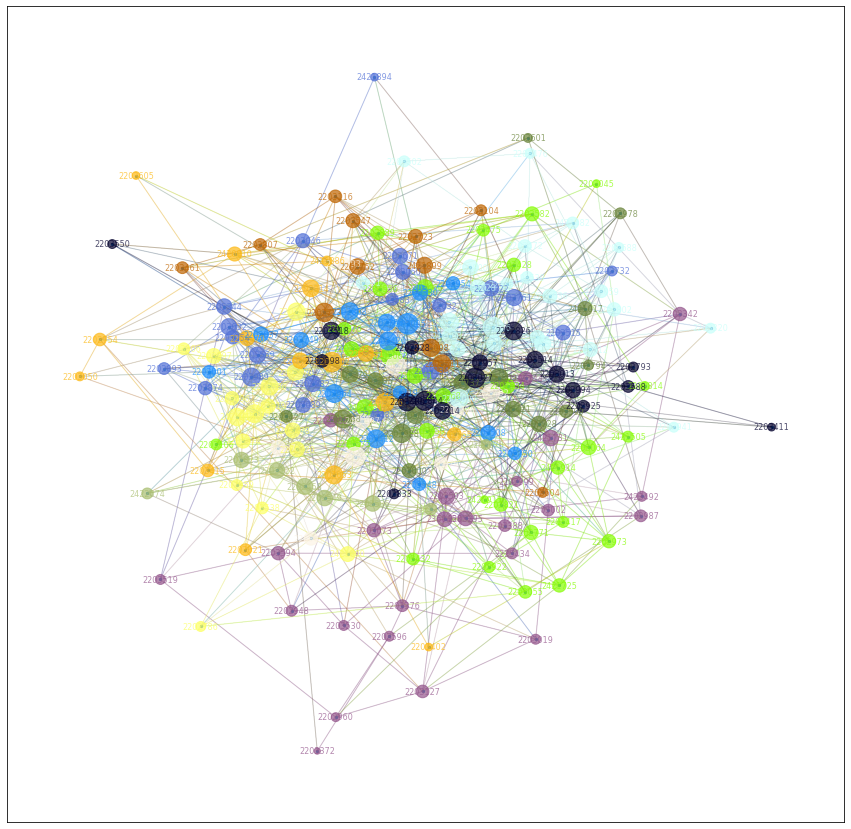

 92% (13 of 14) |######################  | Elapsed Time: 0:00:15 ETA:   0:00:01

This is the result of day 14
0 nodes whose degree is zero are removed
max No. of community: 9
num of communities: 10


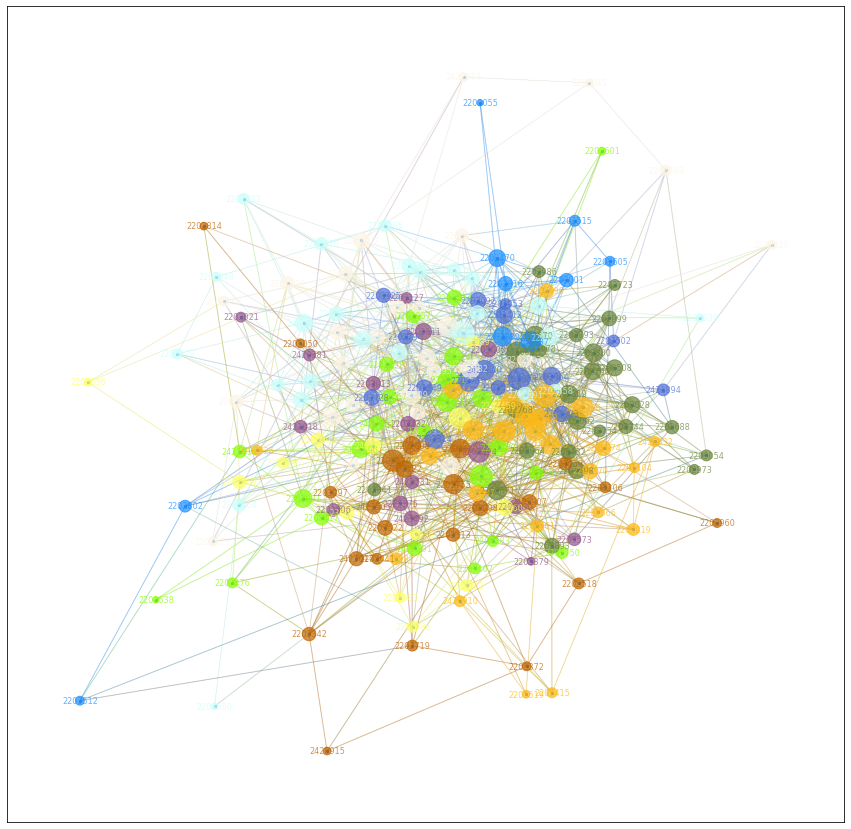

100% (14 of 14) |########################| Elapsed Time: 0:00:17 Time:  0:00:17


In [84]:
# Louvain algorithm
partition_14days = []
Louvain_community_14days = []
nodes_removed_14days = []
bar = progressbar.ProgressBar()
for i in bar(range(0,len(data_dict_list))):
    nodes_removed_1day, Louvain_community_1day, partition_1day = community_Louvain(i,data_dict_list[i].get('Graph'))
    nodes_removed_14days.append(nodes_removed_1day)
    Louvain_community_14days.append(Louvain_community_1day)
    partition_14days.append(partition_1day)

In [99]:
bar = progressbar.ProgressBar()
print('Weighted graph(Louvain)')
for j in bar(range(1,len(data_dict_list))):
    print('Day %d and Day %d :NMI is'%(j,j+1),compute_NMI(j,j+1))

100% (13 of 13) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Weighted graph(Louvain)
Day 1 and Day 2 :NMI is 0.16759813447692676
Day 2 and Day 3 :NMI is 0.17252209534516758
Day 3 and Day 4 :NMI is 0.17823301881476802
Day 4 and Day 5 :NMI is 0.1779000886693532
Day 5 and Day 6 :NMI is 0.1806784392229655
Day 6 and Day 7 :NMI is 0.18664949062514452
Day 7 and Day 8 :NMI is 0.19647767654852966
Day 8 and Day 9 :NMI is 0.1943169009948712
Day 9 and Day 10 :NMI is 0.19383054433438238
Day 10 and Day 11 :NMI is 0.19008037022865967
Day 11 and Day 12 :NMI is 0.18917150182189418
Day 12 and Day 13 :NMI is 0.18838682887016076
Day 13 and Day 14 :NMI is 0.20304846877709426


In [103]:
# Random list NMI
bar = progressbar.ProgressBar()
print('Random list NMI')
for j in bar(range(1,len(data_dict_list))):
    np.random.seed()
    list1 = np.random.randint(low = 0, high = 11, size = 210)
    np.random.seed()
    list2 = np.random.randint(low = 0, high = 11, size = 210)
    NMI = normalized_mutual_info_score(list1,list2)
    print('NMI of random test %d'%(j),NMI)

100% (13 of 13) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Random list NMI
NMI of random test 1 0.10906001721498196
NMI of random test 2 0.12430453215200361
NMI of random test 3 0.10816541413807504
NMI of random test 4 0.13337091332127668
NMI of random test 5 0.14281253422053228
NMI of random test 6 0.11174916648176102
NMI of random test 7 0.15963168793398966
NMI of random test 8 0.10860131106154328
NMI of random test 9 0.11295820255819962
NMI of random test 10 0.13579140945126664
NMI of random test 11 0.1333230388805464
NMI of random test 12 0.16128106860095642
NMI of random test 13 0.11452588971595455


In [8]:
# check the first day community
for c,n in Louvain_community_14days[0].items():
    n.sort()
    print('community',c)
    print('number of nodes in community',len(n))
    print(n)

community 5
number of nodes in community 27
[2202759, 2202771, 2202814, 2202889, 2202988, 2202989, 2202994, 2203032, 2203055, 2203116, 2203122, 2203330, 2203341, 2203346, 2203379, 2203412, 2203417, 2203461, 2203466, 2203470, 2203487, 2203530, 2203593, 2203599, 2225570, 2420910, 2421800]
community 3
number of nodes in community 21
[2202737, 2202744, 2202868, 2202925, 2202970, 2202993, 2203001, 2203050, 2203053, 2203062, 2203089, 2203319, 2203458, 2203492, 2203515, 2203522, 2203535, 2203550, 2203556, 2203606, 2421191]
community 6
number of nodes in community 12
[2202732, 2202754, 2202808, 2203372, 2203376, 2203415, 2203512, 2203518, 2421482, 2421899, 2422632, 2423492]
community 0
number of nodes in community 36
[2202743, 2202821, 2202870, 2202954, 2202959, 2202982, 2203026, 2203028, 2203037, 2203045, 2203061, 2203073, 2203098, 2203106, 2203125, 2203127, 2203134, 2203299, 2203302, 2203314, 2203342, 2203421, 2203475, 2203476, 2203496, 2203514, 2203548, 2203583, 2203588, 2203596, 2203604, 2

In [9]:
for c,n in Louvain_community_14days[1].items():
    n.sort()
    print('community',c)
    print('number of nodes in community',len(n))
    print(n)

community 9
number of nodes in community 22
[2202671, 2202732, 2202786, 2202794, 2202925, 2202973, 2202978, 2203002, 2203054, 2203061, 2203066, 2203125, 2203372, 2203411, 2203483, 2203583, 2203594, 2203596, 2360458, 2421505, 2421706, 2421725]
community 1
number of nodes in community 12
[2202800, 2202809, 2202948, 2203299, 2203327, 2203406, 2203427, 2203430, 2203472, 2203487, 2421017, 2421914]
community 2
number of nodes in community 26
[2202720, 2202765, 2202796, 2202814, 2202959, 2203000, 2203060, 2203064, 2203070, 2203127, 2203279, 2203295, 2203314, 2203379, 2203415, 2203428, 2203459, 2203466, 2203492, 2203569, 2203573, 2203593, 2203605, 2421018, 2421899, 2423492]
community 0
number of nodes in community 10
[2202999, 2203001, 2203028, 2203041, 2203050, 2203098, 2203342, 2203496, 2203542, 2421191]
community 4
number of nodes in community 11
[2202802, 2203014, 2203046, 2203421, 2203475, 2203502, 2203530, 2203582, 2420381, 2420915, 2421894]
community 5
number of nodes in community 20
[2

In [ ]:
'''
def compute_NMI(day1,day2):
    list1 = list(partition_14days[day1-1].values())
    list2 = list(partition_14days[day2-1].values())
    if len(list1)<len(list2):
        rand = np.random.randint(low = 0, high = max(list1)+1, size = len(list2)-len(list1))
        list1.extend(rand)
    elif len(list2)<len(list1):
        rand = np.random.randint(low = 0, high = max(list2)+1, size = len(list1)-len(list2))
        list2.extend(rand)
    else:
        pass
    print(len(list1),len(list2))
    return normalized_mutual_info_score(list1,list2)
'''

In [ ]:
'''
Draft
rand = np.random.randint(low = 0, high = max(partition_14days[0].values())+1, size = 1)
print(partition_14days[0].get(999,rand[0]))
list1=[]
list2=[]
key1set = set(sorted(partition_14days[0]))
key2set = set(sorted(partition_14days[1]))
keylist = list(key1set&key2set)
keylist.sort()
i = 0
for key in keylist:
    list1.append(partition_14days[0].get(key,-1))
    list2.append(partition_14days[1].get(key,-1))
    #i = i+1
    #print(i,key)
normalized_mutual_info_score(list1,list2)
'''